In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load a non-stationary dataset
df1 = pd.read_csv('googl.txt')
#df1.index.freq = 'W'

In [2]:
df1.tail()

Date     Open     High      Low    Close   Volume  OpenInt
3328  2017-11-06  1049.10  1052.59  1042.00  1042.68   913954        0
3329  2017-11-07  1049.65  1053.41  1043.00  1052.39  1303832        0
3330  2017-11-08  1050.05  1062.69  1047.05  1058.29  1214469        0
3331  2017-11-09  1048.00  1050.88  1035.85  1047.72  1793994        0
3332  2017-11-10  1043.87  1046.63  1041.22  1044.15   970498        0

In [3]:
df=df1[~df1['Date'].isnull()]

In [4]:
df.shape

(3333, 7)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df['Date'].min()

Timestamp('2004-08-19 00:00:00')

In [7]:
indexedDataset=df.set_index(['Date'])

In [8]:
indexedDataset=indexedDataset[['Open']]

In [9]:
indexedDataset.head()

Open
Date              
2004-08-19  50.000
2004-08-20  50.505
2004-08-23  55.375
2004-08-24  55.620
2004-08-25  52.480

In [10]:
import matplotlib.pyplot as plt
plt.xlabel('Date')
plt.ylabel('Open')
plt.plot(indexedDataset)

In [11]:
## the mean is not constant and neither the variance
from statsmodels.tsa.stattools import adfuller
acdf_test=adfuller(indexedDataset['Open'],autolag='AIC')
df_output=pd.Series(acdf_test[0:4], index=['Test Statistic','p-value','#lags used','#nobs used'])

In [12]:
print(df_output)
for k,v in acdf_test[4].items():
    print (k,v)
    
##null hypothesis is ::: data is non-stationary
## ftr null.

Test Statistic       1.038048
p-value              0.994652
#lags used          27.000000
#nobs used        3305.000000
dtype: float64
1% -3.4323301471235474
5% -2.8624149121800033
10% -2.567235733713875


In [13]:
import numpy as np
indexedDataset_logscale=np.log(indexedDataset)

In [14]:
indexedDataset_logscale.head()

Open
Date                
2004-08-19  3.912023
2004-08-20  3.922072
2004-08-23  4.014128
2004-08-24  4.018543
2004-08-25  3.960432

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(indexedDataset_logscale, freq=365)
#decomposition = seasonal_decompose(ts_log.price.values, freq=30)

In [16]:
trend=decomposition.trend## these steps produce indiv datasets
seasonal=decomposition.seasonal
residual=decomposition.resid

In [17]:
plt.subplot(411)
plt.plot(indexedDataset_logscale, label='Original')
plt.legend(loc='best')


plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='residual')
plt.legend(loc='best')

In [18]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [85]:
stepwise_fit = auto_arima(indexedDataset['Open'], start_p=1, start_q=1,
                          max_p=4, max_q=4,m=12,
                           seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=24370.330, BIC=24382.546, Fit time=0.343 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=23458.833, BIC=23483.264, Fit time=6.056 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=22169.548, BIC=22193.978, Fit time=19.003 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=22171.420, BIC=22201.958, Fit time=20.456 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=24372.329, BIC=24390.652, Fit time=1.651 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=22171.417, BIC=22201.956, Fit time=53.231 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=22173.544, BIC=22210.190, Fit time=28.153 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasona

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3333
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood              -11081.071
Date:                            Tue, 17 Sep 2019   AIC                          22168.141
Time:                                    21:31:59   BIC                          22186.464
Sample:                                         0   HQIC                         22174.698
                                           - 3333                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      1.477      0.140      -0.001       0.005
ma.S.L12      -0.9936      0.004   -252.529      0.000      -1.001      -0.986
sigma2        45.6851      0.325    140.381      0.000      45.047      46.323
===================================================================================
Ljung-Box (Q):                       81.42   Jarque-Bera (JB):             68938.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
indexedDataset.shape

In [86]:
# Set four weeks for testing
train = indexedDataset.iloc[:3000]##can't do random bc we have to be chronological.
test = indexedDataset.iloc[3000:]##lower prediciton window to get better rmse

In [36]:
test.head()

Open
Date              
2016-07-20  754.05
2016-07-21  757.00
2016-07-22  757.32
2016-07-25  757.68
2016-07-26  757.52

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Open'],order=(0,1,0),seasonal_order=(0, 1, 1, 12),enforce_invertibility=False,enforce_stationarity=True)


results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Open   No. Observations:                 3000
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -9850.618
Date:                            Tue, 17 Sep 2019   AIC                          19705.236
Time:                                    21:33:48   BIC                          19717.240
Sample:                                         0   HQIC                         19709.555
                                           - 3000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0030      0.007   -140.115      0.000      -1.017      -0.989
sigma2        41.7703      0.549     76.133      0.000      40.695      42.846
===================================================================================
Ljung-Box (Q):                       76.27   Jarque-Bera (JB):             94287.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.62   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
# Obtain predicted values
start=len(train)##400 
end=len(train)+len(test)-1  ## end at 433
predictions = results.predict(start=start, end=end, dynamic=False)

In [40]:
test.tail()

Open
Date               
2017-11-06  1049.10
2017-11-07  1049.65
2017-11-08  1050.05
2017-11-09  1048.00
2017-11-10  1043.87

In [89]:
predictions=predictions.reset_index().drop(['index'],axis=1)
predictions

0
0    749.568271
1    750.056294
2    750.834589
3    751.186846
4    751.226213
5    750.984778
6    751.285787
7    751.801134
8    751.911290
9    751.858716
10   752.423483
11   752.766687
12   752.464958
13   752.952982
14   753.731276
15   754.083533
16   754.122900
17   753.881465
18   754.182474
19   754.697822
20   754.807978
21   754.755403
22   755.320170
23   755.663374
24   755.361645
25   755.849669
26   756.627963
27   756.980220
28   757.019587
29   756.778152
..          ...
303  823.604024
304  823.643391
305  823.401956
306  823.702965
307  824.218312
308  824.328468
309  824.275894
310  824.840661
311  825.183865
312  824.882136
313  825.370160
314  826.148454
315  826.500711
316  826.540078
317  826.298643
318  826.599652
319  827.115000
320  827.225156
321  827.172581
322  827.737348
323  828.080552
324  827.778823
325  828.266847
326  829.045141
327  829.397399
328  829.436765
329  829.195330
330  829.496339
331  830.011687
332  830.121843

[333 rows x 1 columns]

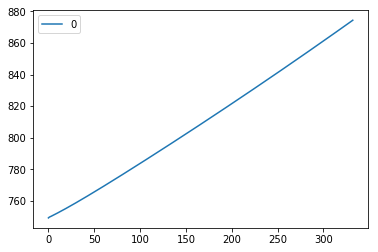

In [69]:
# Plot predictions against known values
title='Googl'
ylabel='Count'
xlabel=''

#ax = test['Open'].plot(legend=True,figsize=(12,6),title=title)
predictions[0].plot(legend=True)
#ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel)

In [101]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions')

In [100]:
test=test.reset_index()

In [102]:
predictions=pd.DataFrame(predictions)
predictions=predictions.reset_index()

In [103]:
compare=pd.DataFrame(predictions).join(test)

In [104]:
compare.head()

index  Predictions       Date    Open
0   3000   749.568271 2016-07-20  754.05
1   3001   750.056294 2016-07-21  757.00
2   3002   750.834589 2016-07-22  757.32
3   3003   751.186846 2016-07-25  757.68
4   3004   751.226213 2016-07-26  757.52

In [105]:
compare=compare.drop(['index'],axis=1)

In [108]:
compare=compare.set_index('Date')

In [109]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse =rmse(compare['Predictions'], compare['Open'])
mse = mean_squared_error(compare['Predictions'], compare['Open'])
print(f' MSE Error: {rmse:11.10}')
print(f' MSE Error: {mse:11.10}')

 MSE Error: 107.5425894
 MSE Error: 11565.40855


In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(indexedDataset['Open'],order=(0,1,0),seasonal_order=(0, 1, 1, 12),enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(indexedDataset),len(indexedDataset)+18,typ='levels').rename('SARIMA Forecast')

##add +30 instead of +18 to forecast out for the future 30 days.

In [113]:
fcast

3333    1043.346934
3334    1044.459384
3335    1045.231590
3336    1044.741393
3337    1045.190005
3338    1045.671538
3339    1046.323064
3340    1046.068144
3341    1046.465413
3342    1046.814341
3343    1048.151253
3344    1048.583025
3345    1048.059959
3346    1049.172409
3347    1049.944615
3348    1049.454418
3349    1049.903030
3350    1050.384563
3351    1051.036089
Name: SARIMA Forecast, dtype: float64

In [114]:
indexedDataset['Open']

Date
2004-08-19      50.000
2004-08-20      50.505
2004-08-23      55.375
2004-08-24      55.620
2004-08-25      52.480
2004-08-26      52.475
2004-08-27      54.050
2004-08-30      52.640
2004-08-31      51.150
2004-09-01      51.350
2004-09-02      49.595
2004-09-03      50.475
2004-09-07      50.505
2004-09-08      50.370
2004-09-09      51.265
2004-09-10      50.800
2004-09-13      53.315
2004-09-14      53.725
2004-09-15      55.280
2004-09-16      56.170
2004-09-17      57.210
2004-09-20      58.475
2004-09-21      59.905
2004-09-22      58.700
2004-09-23      59.420
2004-09-24      60.470
2004-09-27      59.780
2004-09-28      60.650
2004-09-29      63.350
2004-09-30      64.950
                ...   
2017-10-02     975.650
2017-10-03     967.560
2017-10-04     971.760
2017-10-05     972.790
2017-10-06     980.000
2017-10-09     995.000
2017-10-10     995.300
2017-10-11     989.040
2017-10-12    1003.840
2017-10-13    1009.110
2017-10-16    1009.630
2017-10-17    1007.440
2017-1

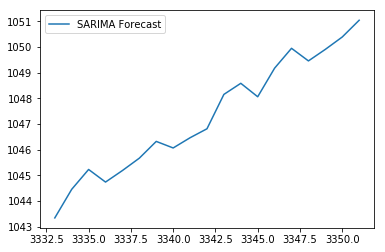

In [115]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'GOOGL Loan Forecast'
#ylabel='Loans Per Week'
#xlabel='' # we don't really need a label here

#ax = indexedDataset['Open'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
#ax.autoscale(axis='x',tight=True)
##ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [116]:
fcast

3333    1043.346934
3334    1044.459384
3335    1045.231590
3336    1044.741393
3337    1045.190005
3338    1045.671538
3339    1046.323064
3340    1046.068144
3341    1046.465413
3342    1046.814341
3343    1048.151253
3344    1048.583025
3345    1048.059959
3346    1049.172409
3347    1049.944615
3348    1049.454418
3349    1049.903030
3350    1050.384563
3351    1051.036089
Name: SARIMA Forecast, dtype: float64